In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)

In [ ]:
def slope(x1,y1,x2,y2):
    ###finding slope
    if x2!=x1:
        return((y2-y1)/(x2-x1))
    else:
        return 'NA'

def drawLine(image,x1,y1,x2,y2):

    m=slope(x1,y1,x2,y2)
    h,w=image.shape[:2]
    if m!='NA':
        ### here we are essentially extending the line to x=0 and x=width
        ### and calculating the y associated with it
        ##starting point
        px=0
        py=-(x1-0)*m+y1
        ##ending point
        qx=w
        qy=-(x2-w)*m+y2
    else:
    ### if slope is zero, draw a line with x=x1 and y=0 and y=height
        px,py=x1,0
        qx,qy=x1,h
    cv2.line(image, (int(px), int(py)), (int(qx), int(qy)), (255, 255, 255), 1)

In [ ]:
def get_contour_areas(contours):
    all_areas = []
    for cnt in contours:
        area= cv2.contourArea(cnt)
        all_areas.append(area)
    return all_areas

In [ ]:
def rearrange_points(corners):
  # Find center
  center = [0]*2
  for i in range(corners.shape[0]):
    center[0] += corners[i][0][0]
    center[1] += corners[i][0][1]
  center[0] /= 4
  center[1] /= 4

  rearranged = [None]*4
  for i in range(4):
    if corners[i][0][0] < center[0] and corners[i][0][1] > center[1]:
      rearranged[i] = 0
    elif corners[i][0][0] > center[0] and corners[i][0][1] > center[1]:
      rearranged[i] = 1
    elif corners[i][0][0] > center[0] and corners[i][0][1] < center[1]:
      rearranged[i] = 2
    elif corners[i][0][0] < center[0] and corners[i][0][1] < center[1]:
      rearranged[i] = 3

  corners_copy = [None]*4
  for i in range(4):
    corners_copy[rearranged[i]] = [corners[i][0].tolist()]
  return corners_copy

In [ ]:
img = cv2.imread("/content/image.jpg")
img_copy = np.array(img, copy = True)

# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)

# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
mask = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))) 
mask = cv2.GaussianBlur(mask,(5,5),0)

# Find convex hull of contour with largest area
contours, _ = cv2.findContours(image=mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
page = sorted(contours, key=cv2.contourArea, reverse= True)[0]
page = cv2.convexHull(page, False)

# Create a binary image with convex hull
blank_bin = np.zeros_like(img)
cv2.fillPoly(blank_bin, pts =[page], color=(255,255,255))
blank_bin = cv2.cvtColor(blank_bin, cv2.COLOR_BGR2GRAY)

# Canny Edge Detection and contour again to get the outer line of the convex hull
edge_hull = cv2.Canny(image=blank_bin, threshold1=100, threshold2=200)
contours, a = cv2.findContours(image=edge_hull, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
blank_copy = np.array(blank_bin, copy = True)
total = 0
for c in contours:
    epsilon = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)

    cv2.drawContours(blank_copy, [approx], -1, 0, 4)
    total += 1

# Use HoughLinesP to detect straight lines
edge_copy = np.zeros_like(edge_hull)
lines = cv2.HoughLinesP(edge_hull, 1, np.pi/180, 60, minLineLength=10, maxLineGap=250)

# Combine similar lines, then take 4 longest lines as edges for outer quadrilateral of the image
lines = HoughBundler(min_distance=10,min_angle=5).process_lines(lines)
length = np.array([[None]*2 for i in range(lines.shape[0])])
for i in range(len(length)):
  length[i][0] = math.sqrt( (lines[i][0][2]-lines[i][0][0])**2 + (lines[i][0][3] - lines[i][0][1])**2 )
  length[i][1] = i
length_copy = np.flip(length[length[:,0].argsort()])[:4,0]
lines_copy = np.array([None]*4)
for i in range(lines_copy.shape[0]):
  lines_copy[i] = lines[length_copy[i]]
lines = lines_copy

# Extends lines, then use goodFeaturesToTrack to get corners of the quadrilateral, after that use convexHull to rearrange points
edge_copy = np.zeros_like(edges)
for i in range(4):
  drawLine(edge_copy, lines[i][0][0], lines[i][0][1], lines[i][0][2], lines[i][0][3])
corners = cv2.convexHull(np.array(cv2.goodFeaturesToTrack(edge_copy,4,0.01,10), dtype = np.int32), False)
edge_copy = np.zeros_like(edges)

# Fill the convex polygon, find the contours of it
cv2.fillPoly(edge_copy, [corners], color = (255,255,255))
contours, _ = cv2.findContours(image = edge_copy, mode = cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

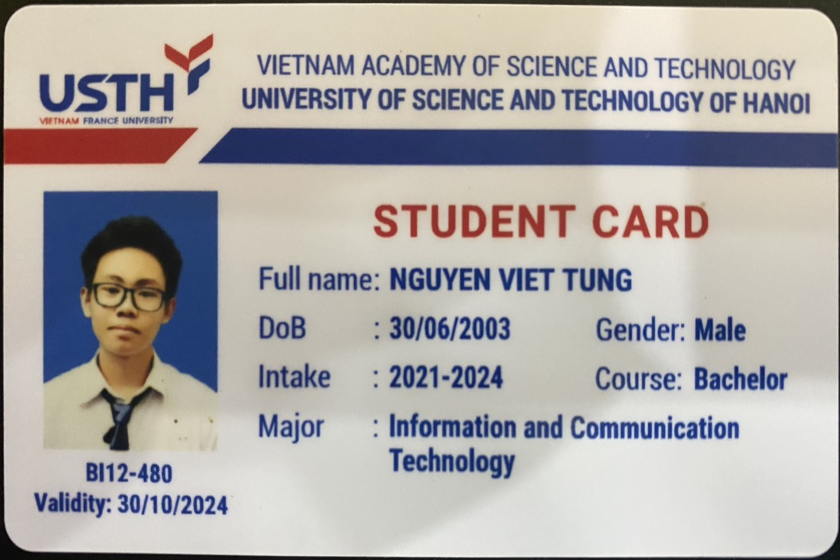

In [ ]:
output_size = [840, 560]
corners = np.float32(rearrange_points(corners))
destination = np.float32([[0,output_size[1]], [output_size[0],output_size[1]], [output_size[0],0], [0,0]])
matrix = cv2.getPerspectiveTransform(corners, destination)
output = cv2.warpPerspective(img_copy, matrix, output_size)
cv2_imshow(output)  